# Bag of words model

In [1]:
!pip install numpy
!pip install torchtext
!pip install torch
!pip install sklearn
!pip install bokeh
!pip install matplotlib

    100% |████████████████████████████████| 71kB 2.9MB/s 
    100% |████████████████████████████████| 591.8MB 23kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x61d5a000 @  0x7f08e358d2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [2]:
import numpy as np

from torchtext import data
from torchtext import datasets
from torchtext.vocab import Vectors

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear
from torch.nn.functional import softmax, relu, tanh
from torchtext.vocab import Vectors, GloVe, CharNGram, FastText

import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool
from bokeh.io import output_notebook, show, push_notebook
output_notebook()


Loading BokehJS ...

In [0]:
use_cuda = torch.cuda.is_available()

def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x

def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

## SST

In [4]:
TEXT = data.Field(sequential=True)
LABEL = data.Field(sequential=False)

train_set, validation_set, _ = datasets.SST.splits(TEXT,
                                                    LABEL,
                                                    fine_grained=False,
                                                    train_subtrees=True,
                                                    filter_pred=lambda ex: ex.label != 'neutral')

downloading trainDevTestTrees_PTB.zip


trainDevTestTrees_PTB.zip: 100%|██████████| 790k/790k [00:00<00:00, 861kB/s]


extracting


In [5]:
print('train.fields', train_set.fields)
print('len(train)', len(train_set))
print('vars(train[0])', vars(train_set[0]))
print()
print('Example 2', vars(train_set[17]))

train.fields {'text': <torchtext.data.field.Field object at 0x7f9109cadbe0>, 'label': <torchtext.data.field.Field object at 0x7f9109cadc18>}
len(train) 98794
vars(train[0]) {'text': ['The', 'Rock', 'is', 'destined', 'to', 'be', 'the', '21st', 'Century', "'s", 'new', '``', 'Conan', "''", 'and', 'that', 'he', "'s", 'going', 'to', 'make', 'a', 'splash', 'even', 'greater', 'than', 'Arnold', 'Schwarzenegger', ',', 'Jean-Claud', 'Van', 'Damme', 'or', 'Steven', 'Segal', '.'], 'label': 'positive'}

Example 2 {'text': ['The', 'gorgeously', 'elaborate', 'continuation', 'of', '``', 'The', 'Lord', 'of', 'the', 'Rings', "''", 'trilogy', 'is', 'so', 'huge', 'that', 'a', 'column', 'of', 'words', 'can', 'not', 'adequately', 'describe', 'co-writer\\/director', 'Peter', 'Jackson', "'s", 'expanded', 'vision', 'of', 'J.R.R.', 'Tolkien', "'s", 'Middle-earth', '.'], 'label': 'positive'}


In [7]:
# build the vocabulary
url = 'https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.simple.vec'
#url = 'http://nlp.stanford.edu/data/glove.840B.300d.zip'
#TEXT.build_vocab(train_set, max_size=None, vectors=Vectors('wiki.simple.vec', url=url))
TEXT.build_vocab(train_set,vectors=GloVe(name='840B',dim='300'))
LABEL.build_vocab(train_set)
# print vocab information
print('len(TEXT.vocab)', len(TEXT.vocab))
print('TEXT.vocab.vectors.size()', TEXT.vocab.vectors.size())


.vector_cache/glove.840B.300d.zip: 2.18GB [00:55, 39.6MB/s]                            
100%|█████████▉| 2195617/2196017 [05:31<00:00, 7882.17it/s]

len(TEXT.vocab) 18003
TEXT.vocab.vectors.size() torch.Size([18003, 300])


In [8]:
# make iterator for splits
train_iter, val_iter, _ = data.BucketIterator.splits(
    (train_set, validation_set, _), batch_size=32)


torch.Size([21, 32])
tensor([2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 1, 2])


In [9]:
embedding_dim = TEXT.vocab.vectors.size()[1]
num_embeddings = TEXT.vocab.vectors.size()[0]
num_classes = len(LABEL.vocab.itos)

dropout_rate = 0.2

input_dim = 200

con_dim = 200

# build the BoW model
class BoWNet(nn.Module):

    def __init__(self):
        super(BoWNet, self).__init__()
        self.embeddings = nn.Embedding(num_embeddings, embedding_dim)
        self.embeddings.weight.data.copy_(TEXT.vocab.vectors)
        
        
        self.input = Linear(in_features = embedding_dim,
                             out_features = input_dim,
                             bias = True)
        
        self.l_1 = Linear(in_features=con_dim,
                           out_features=con_dim,
                           bias = True)
        self.l_2 = Linear(in_features=con_dim,
                           out_features=con_dim,
                           bias= True)
        self.l_3 = Linear(in_features= con_dim,
                           out_features = con_dim,
                           bias = True)
        
        self.drop = nn.Dropout(p = dropout_rate)
        
        # output layer
        self.l_out = Linear(in_features=con_dim,
                            out_features=num_classes,
                            bias=False)
        
    def forward(self, x):
        out = {}
        
        x = self.embeddings(x) # (bs,len,300)
        
        x = self.drop(x)
        
        #sum_x =  # (bs,300) 

        
        sum_x = torch.sum(x,0)
        
        
        #tanh # (bs,100)
        
        sum_x = torch.tanh(self.input(sum_x))
        z = sum_x
        
        z = torch.tanh(self.l_1(z))     
        z = torch.tanh(self.l_2(z))
        z = torch.tanh(self.l_3(z))

        # Softmax
        out['out'] = softmax(self.l_out(z), dim = 1)
        return out

net = BoWNet()
print(net)

BoWNet(
  (embeddings): Embedding(18003, 300)
  (input): Linear(in_features=300, out_features=200, bias=True)
  (l_1): Linear(in_features=200, out_features=200, bias=True)
  (l_2): Linear(in_features=200, out_features=200, bias=True)
  (l_3): Linear(in_features=200, out_features=200, bias=True)
  (drop): Dropout(p=0.2)
  (l_out): Linear(in_features=200, out_features=3, bias=False)
)


In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(),lr=0.001,amsgrad=True,weight_decay=0.00001)

def accuracy(ys, ts):
    correct_prediction = torch.eq(torch.max(ys, 1)[1], ts)
    return torch.mean(correct_prediction.float())

## TRAINING BOW WITH SST

In [13]:
max_iter = 3000
eval_every = 1000
log_every = 200

train_loss, train_accs, train_iter_list = [], [], []
train_loss_list, train_accs_list = [],[]
val_loss_list, val_accs_list, val_iter_list = [],[], []


max_acc = 0
max_acc_idx = 0
epochs = 1
reached_max = False

net.train()
while reached_max == False:
    print("EPOCH NR: " + str(epochs))
    for i, batch in enumerate(train_iter):
        if i % eval_every == 0:
            net.eval()
            val_losses, val_accs, val_lengths = 0, 0, 0
      #  val_meta = {'label_idx': [], 'sentences': [], 'labels': []}
            for val_batch in val_iter:
                output = net(val_batch.text)
            # batches sizes might vary, which is why we cannot just mean the batch's loss
            # we multiply the loss and accuracies with the batch's size,
            # to later divide by the total size
                val_losses += criterion(output['out'], val_batch.label) * val_batch.batch_size
                val_accs += accuracy(output['out'], val_batch.label) * val_batch.batch_size
                val_lengths += val_batch.batch_size
            

        
        # divide by the total accumulated batch sizes
            val_losses /= val_lengths
            val_accs /= val_lengths
        
            val_loss_list.append(get_numpy(val_losses))
            val_accs_list.append(get_numpy(val_accs))
            val_iter_list.append(i)
        
            print("valid, it: {} loss: {:.2f} accs: {:.2f}\n".format(i, get_numpy(val_losses), get_numpy(val_accs)))
          
            net.train()
    
        output = net(batch.text)
        batch_loss = criterion(output['out'], batch.label)
    
        train_loss.append(get_numpy(batch_loss))
        train_accs.append(get_numpy(accuracy(output['out'], batch.label)))
 
    
        optimizer.zero_grad()
        batch_loss.backward()
        nn.utils.clip_grad_norm_(net.parameters(),max_norm=0.5)
        optimizer.step()
    
        if i % log_every == 0:        
            print("train, it: {} loss: {:.2f} accs: {:.2f}".format(i, 
                                                               np.mean(train_loss), 
                                                               np.mean(train_accs)))
        # reset
            train_loss_list.append(np.mean(train_loss))
            train_accs_list.append(np.mean(train_accs))    
            train_iter_list.append(i)
            train_loss, train_accs = [], []
    if max(val_accs_list[max_acc_idx:len(val_accs_list)]) > max_acc:
        max_acc = max(val_accs_list[max_acc_idx:len(val_accs_list)])
        max_acc_idx = np.argmax(max(val_accs_list[max_acc_idx:len(val_accs_list)]))
    else:
        print("Maximum validation accuracy: " + str(max_acc))
        reached_max = True
        break
    epochs += 1

EPOCH NR: 1
valid, it: 0 loss: 1.10 accs: 0.16

train, it: 0 loss: 1.10 accs: 0.31
train, it: 200 loss: 0.77 accs: 0.78
train, it: 400 loss: 0.74 accs: 0.81
train, it: 600 loss: 0.74 accs: 0.81
train, it: 800 loss: 0.73 accs: 0.81
valid, it: 1000 loss: 0.78 accs: 0.76

train, it: 1000 loss: 0.77 accs: 0.78
train, it: 1200 loss: 0.74 accs: 0.81
train, it: 1400 loss: 0.75 accs: 0.80
train, it: 1600 loss: 0.73 accs: 0.81
train, it: 1800 loss: 0.74 accs: 0.81
valid, it: 2000 loss: 0.80 accs: 0.75

train, it: 2000 loss: 0.76 accs: 0.79
train, it: 2200 loss: 0.76 accs: 0.79
train, it: 2400 loss: 0.73 accs: 0.82
train, it: 2600 loss: 0.75 accs: 0.80
train, it: 2800 loss: 0.73 accs: 0.82
valid, it: 3000 loss: 0.77 accs: 0.78

train, it: 3000 loss: 0.74 accs: 0.81
EPOCH NR: 2
valid, it: 0 loss: 0.78 accs: 0.76

train, it: 0 loss: 0.72 accs: 0.83
train, it: 200 loss: 0.72 accs: 0.82
train, it: 400 loss: 0.72 accs: 0.83
train, it: 600 loss: 0.72 accs: 0.83
train, it: 800 loss: 0.71 accs: 0.84
val

In [0]:
for i in range(int(len(train_iter_list)/(epochs)),len(train_iter_list)):
    if train_iter_list[i] == 0:
        train_iter_list[i] = train_iter_list[i-1]+1
        continue
    else:
        train_iter_list[i] = train_iter_list[i-1] + log_every


for i in range(int(len(val_iter_list)/epochs),len(val_iter_list)):
    if val_iter_list[i] == 0:
        val_iter_list[i] =val_iter_list[i-1]+1
        continue
    else:
        val_iter_list[i] = val_iter_list[i-1] + eval_every

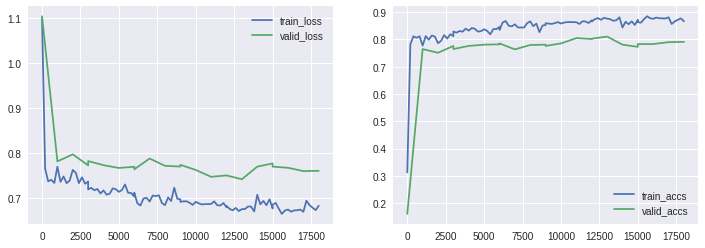

In [15]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(train_iter_list, train_loss_list, label='train_loss')
plt.plot(val_iter_list, val_loss_list, label='valid_loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_iter_list, train_accs_list, label='train_accs')
plt.plot(val_iter_list, val_accs_list, label='valid_accs')
plt.legend()
plt.show()

## SNLI

In [5]:
print("Run test on SNLI...")
TEXT = datasets.nli.ParsedTextField()
LABEL = data.LabelField()
TREE = datasets.nli.ShiftReduceField()

train, val, test = datasets.SNLI.splits(TEXT, LABEL, TREE)

print("Fields:", train.fields)
print("Number of examples:\n", len(train))
print("First Example instance:\n", vars(train[0]))

url = 'https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.simple.vec'
#TEXT.build_vocab(train, max_size=None, vectors=Vectors('wiki.simple.vec', url=url))
TEXT.build_vocab(train_set,vectors=GloVe(name='840B',dim='300'))
LABEL.build_vocab(train)


train_iter, val_iter, test_iter = data.Iterator.splits((train, val, test), batch_size=64)


print("Test iters function")

batch = next(iter(train_iter))
print("Numericalize premises:\n", batch.premise)
print("Numericalize hypotheses:\n", batch.hypothesis)
print("Entailment labels:\n", batch.label)


Run test on SNLI...
downloading snli_1.0.zip


snli_1.0.zip: 100%|██████████| 94.6M/94.6M [00:05<00:00, 15.8MB/s]


extracting


.vector_cache/wiki.simple.vec: 0.00B [00:00, ?B/s]

Fields: {'premise': <torchtext.datasets.nli.ParsedTextField object at 0x7fd73f66d5c0>, 'premise_transitions': <torchtext.datasets.nli.ShiftReduceField object at 0x7fd73f67b7f0>, 'hypothesis': <torchtext.datasets.nli.ParsedTextField object at 0x7fd73f66d5c0>, 'hypothesis_transitions': <torchtext.datasets.nli.ShiftReduceField object at 0x7fd73f67b7f0>, 'label': <torchtext.data.field.LabelField object at 0x7fd73f674cc0>}
Number of examples:
 549367
First Example instance:
 {'premise': ['A', 'person', 'on', 'a', 'horse', 'jumps', 'over', 'a', 'broken', 'down', 'airplane', '.'], 'premise_transitions': ['shift', 'shift', 'reduce', 'shift', 'shift', 'shift', 'reduce', 'reduce', 'reduce', 'shift', 'shift', 'shift', 'shift', 'shift', 'shift', 'reduce', 'reduce', 'reduce', 'reduce', 'reduce', 'shift', 'reduce', 'reduce'], 'hypothesis': ['A', 'person', 'is', 'training', 'his', 'horse', 'for', 'a', 'competition', '.'], 'hypothesis_transitions': ['shift', 'shift', 'reduce', 'shift', 'shift', 'shift

.vector_cache/wiki.simple.vec: 293MB [00:09, 30.1MB/s]                           
 99%|█████████▉| 110275/111051 [00:12<00:00, 8448.37it/s]

Test iters function
Numericalize premises:
 (tensor([[   4,   58,   14,  ...,   14,    4,   20],
        [  46, 1792,   34,  ...,   25,    8,   48],
        [  21, 2668,    6,  ...,   21,    5, 1599],
        ...,
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1]]), tensor([18,  8, 11, 11,  9, 15, 42, 11, 14, 18, 12, 20, 14, 19, 12, 12, 11, 20,
         8, 15, 20,  9, 16, 23, 11, 11, 17, 18, 13, 16, 20, 10, 14,  7, 17, 16,
        17, 13, 11,  8, 21, 12, 17, 14, 13, 14, 12, 18, 10, 17, 12, 12, 17, 12,
        15, 27,  8,  9, 11, 13, 10, 15, 19, 10]))
Numericalize hypotheses:
 (tensor([[  4,   4,   4,  ...,   7,   4,  20],
        [  8,   8,  34,  ...,  25,   8,  64],
        [  6, 581,   6,  ...,   6,  21,  11],
        ...,
        [  1,   1,   1,  ...,   1,   1,   1],
        [  1,   1,   1,  ...,   1,   1,   1],
        [  1,   1,   1,  ...,   1,   1,   1]]), tensor([11,  7,  7, 

In [6]:

print(TEXT.vocab.vectors.size()[0])
print(len(LABEL.vocab.itos))

42392
3


In [7]:
# size of embeddings
embedding_dim = TEXT.vocab.vectors.size()[1]
num_embeddings = TEXT.vocab.vectors.size()[0]
num_classes = len(LABEL.vocab.itos)

input_dim = 100

con_dim = 200

dropout_rate = 0.2

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.embeddings = nn.Embedding(num_embeddings, embedding_dim)
        # use pretrained embeddings
        self.embeddings.weight.data.copy_(TEXT.vocab.vectors)
        
        
        self.input = Linear(in_features = embedding_dim,
                             out_features = input_dim,
                             bias =True)

        self.l_1 = Linear(in_features=con_dim,
                          out_features=con_dim,
                          bias=True)

        self.l_2 = Linear(in_features=con_dim,
                           out_features=con_dim,
                           bias=True)
        self.l_3 = Linear(in_features=con_dim,
                           out_features = con_dim,
                           bias =True)
        
        self.drop = nn.Dropout(p = dropout_rate)
        
        
        # output layer
        self.l_out = Linear(in_features=con_dim,
                            out_features=num_classes,
                            bias=False)
        
    def forward(self, x, y):
        out = {}
        # get embeddings

        x = self.embeddings(x[0])
        y = self.embeddings(y[0])
        
        x = self.drop(x)
        y = self.drop(y)
        
        x = torch.sum(x, dim=0)
        
        y = torch.sum(y, dim=0)
        
        x = torch.tanh(self.input(x))
        y = torch.tanh(self.input(y))
        
        x = torch.cat((x,y),1)

        x = torch.tanh(self.l_1(x))
        x = torch.tanh(self.l_2(x))
        x = torch.tanh(self.l_2(x))

        # Softmax
        out['out'] = softmax(self.l_out(x), dim=1)
        return out

net = Net()
if use_cuda:
    net.cuda()
print(net)

Net(
  (embeddings): Embedding(42392, 300)
  (input): Linear(in_features=300, out_features=100, bias=True)
  (l_1): Linear(in_features=200, out_features=200, bias=True)
  (l_2): Linear(in_features=200, out_features=200, bias=True)
  (l_3): Linear(in_features=200, out_features=200, bias=True)
  (drop): Dropout(p=0.2)
  (l_out): Linear(in_features=200, out_features=3, bias=False)
)


In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(),lr=0.001,amsgrad=True,weight_decay=0.00001)

def accuracy(ys, ts):
    correct_prediction = torch.eq(torch.max(ys, 1)[1], ts)
    return torch.mean(correct_prediction.float())

In [0]:
max_iter = 3000
eval_every = 1000
log_every = 200

train_loss, train_accs, train_iter_list = [], [], []
train_loss_list, train_accs_list = [],[]
val_loss_list, val_accs_list, val_iter_list = [],[], []


max_acc = 0
max_acc_idx = 0
epochs = 1
reached_max = False

net.train()
while reached_max == False:
    print("EPOCH NR: " + str(epochs))
    for i, batch in enumerate(train_iter):
        if i % eval_every == 0:
            net.eval()
            val_losses, val_accs, val_lengths = 0, 0, 0
      #  val_meta = {'label_idx': [], 'sentences': [], 'labels': []}
            for val_batch in val_iter:
                output = net(val_batch.premise,val_batch.hypothesis)
            # batches sizes might vary, which is why we cannot just mean the batch's loss
            # we multiply the loss and accuracies with the batch's size,
            # to later divide by the total size
                val_losses += criterion(output['out'], val_batch.label) * val_batch.batch_size
                val_accs += accuracy(output['out'], val_batch.label) * val_batch.batch_size
                val_lengths += val_batch.batch_size
            

        
        # divide by the total accumulated batch sizes
            val_losses /= val_lengths
            val_accs /= val_lengths
        
            val_loss_list.append(get_numpy(val_losses))
            val_accs_list.append(get_numpy(val_accs))
            val_iter_list.append(i)
        
            print("valid, it: {} loss: {:.2f} accs: {:.2f}\n".format(i, get_numpy(val_losses), get_numpy(val_accs)))
        
            net.train()
    
        output = net(batch.premise,batch.hypothesis)
        batch_loss = criterion(output['out'], batch.label)
    
        train_loss.append(get_numpy(batch_loss))
        train_accs.append(get_numpy(accuracy(output['out'], batch.label)))
 
    
        optimizer.zero_grad()
        batch_loss.backward()
        nn.utils.clip_grad_norm_(net.parameters(),max_norm=0.5)
        optimizer.step()
    
        if i % log_every == 0:        
            print("train, it: {} loss: {:.2f} accs: {:.2f}".format(i, 
                                                               np.mean(train_loss), 
                                                               np.mean(train_accs)))
        # reset
            train_loss_list.append(np.mean(train_loss))
            train_accs_list.append(np.mean(train_accs))    
            train_iter_list.append(i)
            train_loss, train_accs = [], []
    if max(val_accs_list[max_acc_idx:len(val_accs_list)]) > max_acc:
        max_acc = max(val_accs_list[max_acc_idx:len(val_accs_list)])
        max_acc_idx = np.argmax(max(val_accs_list[max_acc_idx:len(val_accs_list)]))
    else:
        print("Maximum validation accuracy: " + str(max_acc))
        reached_max = True
        break
    epochs += 1

EPOCH NR: 1
valid, it: 0 loss: 1.10 accs: 0.33

train, it: 0 loss: 1.10 accs: 0.38
train, it: 200 loss: 1.01 accs: 0.51
train, it: 400 loss: 0.96 accs: 0.57
train, it: 600 loss: 0.95 accs: 0.58
train, it: 800 loss: 0.95 accs: 0.59
valid, it: 1000 loss: 0.95 accs: 0.58

train, it: 1000 loss: 0.94 accs: 0.59
train, it: 1200 loss: 0.94 accs: 0.59
train, it: 1400 loss: 0.93 accs: 0.60
train, it: 1600 loss: 0.93 accs: 0.60
train, it: 1800 loss: 0.93 accs: 0.61
valid, it: 2000 loss: 0.92 accs: 0.62

train, it: 2000 loss: 0.93 accs: 0.61
train, it: 2200 loss: 0.93 accs: 0.60
train, it: 2400 loss: 0.92 accs: 0.61
train, it: 2600 loss: 0.92 accs: 0.61
train, it: 2800 loss: 0.92 accs: 0.62
valid, it: 3000 loss: 0.91 accs: 0.62

train, it: 3000 loss: 0.92 accs: 0.62
train, it: 3200 loss: 0.91 accs: 0.62
train, it: 3400 loss: 0.91 accs: 0.62
train, it: 3600 loss: 0.91 accs: 0.62
train, it: 3800 loss: 0.91 accs: 0.62
valid, it: 4000 loss: 0.91 accs: 0.63

train, it: 4000 loss: 0.91 accs: 0.63
train

In [1]:
for i in range(int(len(train_iter_list)/(epochs)),len(train_iter_list)):
    if train_iter_list[i] == 0:
        train_iter_list[i] = train_iter_list[i-1]+1
        continue
    else:
        train_iter_list[i] = train_iter_list[i-1] + log_every


for i in range(int(len(val_iter_list)/epochs),len(val_iter_list)):
    if val_iter_list[i] == 0:
        val_iter_list[i] =val_iter_list[i-1]+1
        continue
    else:
        val_iter_list[i] = val_iter_list[i-1] + eval_every

NameError: ignored

In [0]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(train_iter_list, train_loss_list, label='train_loss')
plt.plot(val_iter_list, val_loss_list, label='valid_loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_iter_list, train_accs_list, label='train_accs')
plt.plot(val_iter_list, val_accs_list, label='valid_accs')
plt.legend()
plt.show()